In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

from donut import complete_timestamp, standardize_kpi

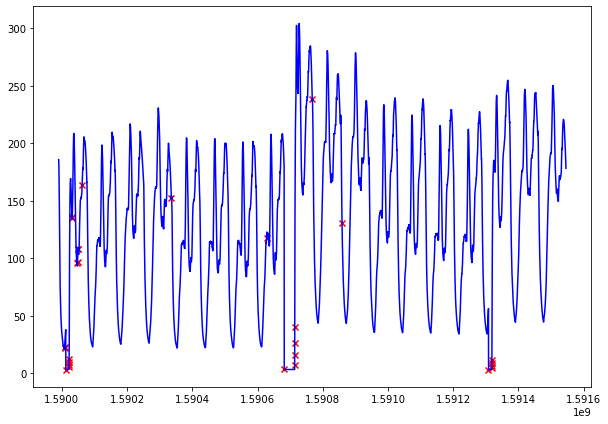

In [2]:
df_series = pd.read_csv('./data/train/0')
df_series['time'] = df_series['time'].apply(lambda x: int(datetime.strptime(x, '%Y-%m-%d %H:%M:%S').timestamp()))
df_alert = df_series[df_series['alert_flag'] == 1]
plt.figure(figsize=(10, 7))
plt.plot(df_series['time'], df_series['value'], color='blue')
plt.scatter(df_alert['time'], df_alert['value'], marker='x', color='red')
plt.show()

In [3]:
timestamp, values, labels = df_series['time'], df_series['value'], df_series['alert_flag']
timestamp, missing, (values, labels) = complete_timestamp(timestamp, (values, labels))

# split the training and testing data
test_portion = 0.3
test_n = int(len(values) * test_portion)
train_values, test_values = values[:-test_n], values[-test_n:]
train_labels, test_labels = labels[:-test_n], labels[-test_n:]
train_missing, test_missing = missing[:-test_n], missing[-test_n:]

# standardize the training and testing data
train_values, mean, std = standardize_kpi(train_values, excludes=np.logical_or(train_labels, train_missing))
test_values, _, _ = standardize_kpi(test_values, mean=mean, std=std)
print(test_values)

[0.13845459 0.12204878 0.10428189 ... 0.71638614 0.7135938  0.7069617 ]


In [4]:
import tensorflow as tf
from donut import Donut
from tensorflow import keras as K
from tfsnippet.modules import Sequential

with tf.variable_scope('model') as model_vs:
    model = Donut(
        h_for_p_x = Sequential([
            K.layers.Dense(100, kernel_regularizer=K.regularizers.l2(0.001), activation=tf.nn.relu),
            K.layers.Dense(100, kernel_regularizer=K.regularizers.l2(0.001), activation=tf.nn.relu)
        ]),
        h_for_q_z = Sequential([
            K.layers.Dense(100, kernel_regularizer=K.regularizers.l2(0.001), activation=tf.nn.relu),
            K.layers.Dense(100, kernel_regularizer=K.regularizers.l2(0.001), activation=tf.nn.relu)
        ]),
        x_dims = 120,
        z_dims = 5,
    )

-194.982
[Epoch 35/256, Step 1700, ETA 39.08s] step time: 0.003009s (±0.009314s); valid time: 0.09353s; loss: -203.222 (±6.44229); valid loss: -204.487 (*)
[Epoch 37/256, Step 1800, ETA 38.23s] step time: 0.002282s (±0.001652s); valid time: 0.01596s; loss: -202.943 (±5.91875); valid loss: -190.457
[Epoch 39/256, Step 1900, ETA 37.47s] step time: 0.002263s (±0.001437s); valid time: 0.01396s; loss: -203.857 (±8.10453); valid loss: -188.954
[Epoch 40/256, Step 1960, ETA 36.95s] Learning rate decreased to 0.00031640625000000006
[Epoch 41/256, Step 2000, ETA 36.72s] step time: 0.002266s (±0.00128s); valid time: 0.01197s; loss: -203.622 (±7.91405); valid loss: -200.793
[Epoch 43/256, Step 2100, ETA 36.04s] step time: 0.002253s (±0.001696s); valid time: 0.01596s; loss: -207.839 (±6.68583); valid loss: -203.501
[Epoch 45/256, Step 2200, ETA 36.01s] step time: 0.0036s (±0.01358s); valid time: 0.1367s; loss: -210.481 (±5.76126); valid loss: -206.598 (*)
[Epoch 47/256, Step 2300, ETA 35.27s] step

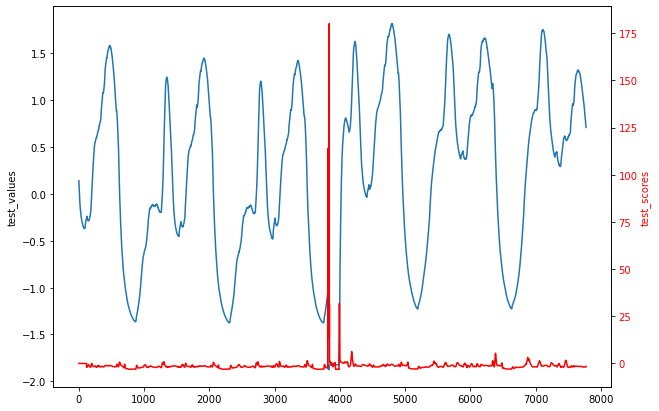

In [5]:
from donut import DonutTrainer, DonutPredictor
from tfsnippet.utils import get_variables_as_dict, VariableSaver

save_dir = '.'

trainer = DonutTrainer(model=model, model_vs=model_vs)
predictor = DonutPredictor(model)

with tf.Session().as_default():
    trainer.fit(train_values, train_labels, train_missing, mean, std)
    test_score = predictor.get_score(test_values, test_missing)

    # save and restore a trained model
    var_dict = get_variables_as_dict(model_vs)
    # save variables to `save_dir`
    saver = VariableSaver(var_dict, save_dir)
    saver.save()

    print('var_dict is:\n{}'.format(var_dict))
    print('saver is:\n{}'.format(saver))

    # check test_value and test_score length

    print(len(test_values))
    print(len(test_score))

    # fix test_score with brute force
    
    test_score = np.concatenate(([0 for i in range(119)], test_score))

    # plot
    
    fig = plt.figure(figsize=(10, 7))
    ax1 = fig.add_subplot(111)
    # ax1.plot(df_series['value'])
    ax1.plot(test_values)
    ax1.set_ylabel('test_values')

    ax2 = ax1.twinx()
    ax2.plot(test_score*-1, 'r-')
    ax2.set_ylabel('test_scores', color='r')
    for i in ax2.get_yticklabels():
        i.set_color('r')